# Graph Nural Network Group 20 Assignment Submission:

1. Hemant Kumar Parakh (2023AA05741)
2. Sushil Kumar (2023aa05849)
3. Jitendra Kumar (2023aa05198)
4. MAREEDU RAVI KISHORE VARMA (2023aa05278)
5. K. KAMALAHASAN (2023ab05086)

## Graph Analysis and Subgraph Generation Using GCNs in PyTorch Geometric:

This assignment involves creating and analyzing a graph neural network (GCN) using PyTorch Geometric. It covers loading the OGB dataset, computing graph metrics, visualizing the graph, generating subgraphs, and extracting node embeddings, providing comprehensive insights into graph-based machine learning.

### Import requird libraries and packages

In [4]:
# Install required libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install ogb
!pip install --upgrade ogb
!pip install networkx matplotlib
!pip install pycairo
!pip install cairocffi
!pip install python-igraph



import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# Import libraries
from ogb.nodeproppred import PygNodePropPredDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import ToUndirected
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree

import torch.nn.functional as F
import networkx as nx
import numpy as np
from ogb.nodeproppred import Evaluator
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx, to_undirected

print("Import done")

Found existing installation: torch_scatter 2.1.2+pt25cpu
Uninstalling torch_scatter-2.1.2+pt25cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt25cpu
Found existing installation: torch_sparse 0.6.18+pt25cpu
Uninstalling torch_sparse-0.6.18+pt25cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt25cpu
Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
Found existing installation: torch_cluster 1.6.3+pt25cpu
Uninstalling torch_cluster-1.6.3+pt25cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt25cpu
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcpu/torch_scatter-2.1.2%2Bpt25cpu-cp312-cp312-win_amd64.whl (366 kB)
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcpu/torch_sparse-0.6.18%2Bpt25cpu-cp312-cp312-win_amd64.whl (802 kB)
Looking in links: https://da

  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git 'C:\Users\hemant.parakh.CORP\AppData\Local\Temp\pip-req-build-3oag2gks'


  Cloning https://github.com/pyg-team/pytorch_geometric.git to c:\users\hemant.parakh.corp\appdata\local\temp\pip-req-build-3oag2gks
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ef028547ff4459f6e98fe429d1564bd1d513fc31
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1178459 sha256=838f806295447daf4ef8532d313b300f6c2f0cc78374bccc4240b59febfaa53a
  Stored in directory: C:\Users\hemant.parakh.CORP\AppData\Local\Temp\pip-ephem-wheel-cache-ocb4u_0g\wheels\96\ab\80\5e43250505a6e639df59a3d89c6b45ed5511f70db8d0ac39c7
Successfully built torch-geometric
Import done


 ## Dataset Loading
 
The ogbn-products dataset is an undirected and unweighted graph, representing an Amazon product co-purchasing network [1]. Nodes represent products sold in Amazon, and edges between two products indicate that the products are purchased together. We follow [2] to process node features and target categories. Specifically, node features are generated by extracting bag-of-words features from the product descriptions followed by a Principal Component Analysis to reduce the dimension to 100.

In [6]:
# Load ogbn-products dataset
#dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='/tmp') # Use small dataset to work faster
dataset = PygNodePropPredDataset(name='ogbn-products', root='/tmp')
data = dataset[0]  # Get the graph data
#data = ToUndirected()(data)  # Convert the graph to undirected

from torch_geometric.utils import remove_self_loops
# Check for self-loops
print(f"Number of self-loops before removal: {(data.edge_index[0] == data.edge_index[1]).sum().item()}")

# Remove self-loops
data.edge_index, _ = remove_self_loops(data.edge_index)

# Verify removal
print(f"Number of self-loops after removal: {(data.edge_index[0] == data.edge_index[1]).sum().item()}")
print("printing data...")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1) // 2}")  # Divide by 2 if undirected
print(f"Node feature shape: {data.x.shape}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Edge index (first 5 edges): {data.edge_index[:, :5]}")
print(f"Node features (first 5 nodes): {data.x[:5]}")
print(f"Labels (first 5 nodes): {data.y[:5]}")
print(f"Data representation: {repr(data)}")

print("printing done...")


C:\Users\hemant.parakh.CORP\AppData\Local\anaconda3\Lib\site-packages\ogb\nodeproppred\dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slice

Number of self-loops before removal: 256
Number of self-loops after removal: 0
printing data...
Number of nodes: 2449029
Number of edges: 61859012
Node feature shape: torch.Size([2449029, 100])
Number of classes: 47
Edge index (first 5 edges): tensor([[     0, 152857,      0,  32104,      0],
        [152857,      0,  32104,      0,  23158]])
Node features (first 5 nodes): tensor([[ 3.1933e-02, -1.9586e-01,  5.1996e-02, -6.3349e-02, -2.2987e-01,
         -2.2130e-02,  4.0465e-01, -1.0794e-01,  3.2562e-02,  6.0270e-02,
          1.3270e-01,  4.5856e-01, -9.5493e-02,  2.5118e-01, -2.7464e-02,
          2.0437e-01, -6.5092e-02,  2.8799e-01,  1.5266e-02,  1.3919e-01,
         -2.7391e-01, -1.0493e-01, -2.1358e-02,  2.7579e-01,  4.5625e-02,
         -3.1325e-01, -2.0205e-01, -2.0238e-01, -3.1769e-01,  7.9290e-02,
         -1.0984e-01,  2.1498e-01, -3.4563e-01, -2.2236e-01, -4.0740e-01,
         -1.0198e-01, -4.0942e-01, -5.0210e-03,  4.8593e-01,  3.5642e-01,
          4.4607e-02, -5.4105e-0

## Model Creation Using PyTorch Geometric GCN with NeighborLoader for Node Classification

This code defines a Graph Convolutional Network (GCN) model using PyTorch Geometric, processes the dataset with NeighborLoader for efficient mini-batch training, and trains the model for node classification with dropout and validation.


Epoch: 1, Train Loss: 1.3547, Val Loss: 1.0810, Val Acc: 0.7047
Epoch: 2, Train Loss: 1.2767, Val Loss: 1.0797, Val Acc: 0.7026
Epoch: 3, Train Loss: 1.2737, Val Loss: 1.0817, Val Acc: 0.7034
Epoch: 4, Train Loss: 1.2718, Val Loss: 1.0771, Val Acc: 0.7042
Epoch: 5, Train Loss: 1.2715, Val Loss: 1.0794, Val Acc: 0.7043
Test Loss: 1.0801, Test Accuracy: 0.7039


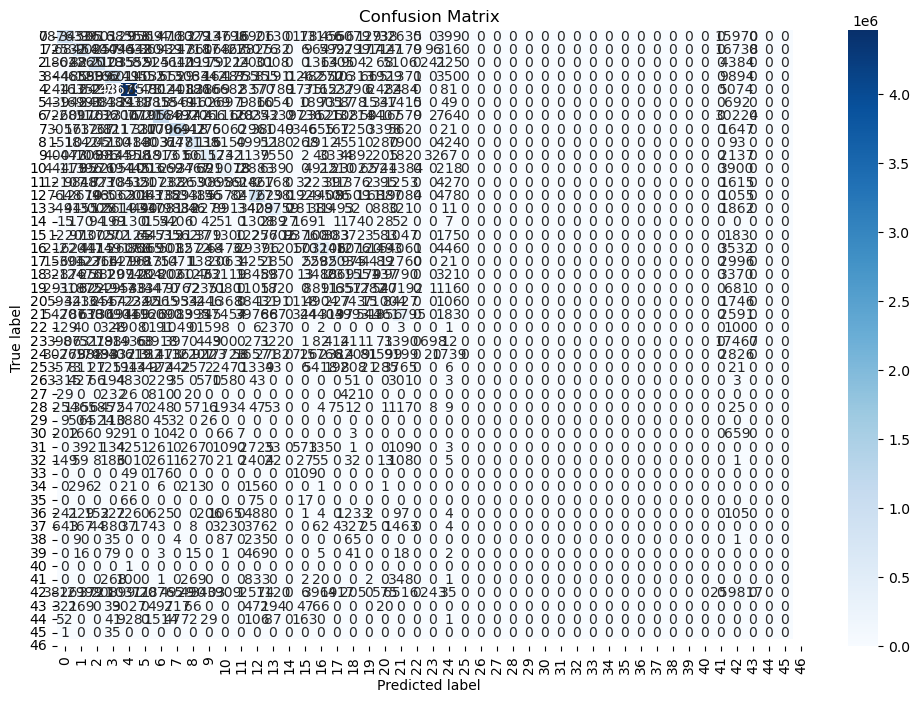

In [8]:
from torch_geometric.loader import NeighborLoader
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the GCN model with Dropout
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = F.dropout(conv(x, edge_index).relu(), p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


# Data Splitting
num_nodes = data.num_nodes
train_idx, test_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

# Normalize features
data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)

# Define NeighborLoader for batching
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[25, 20],
    shuffle=True,
    batch_size=1024,
    pin_memory=True
)

val_loader = NeighborLoader(
    data,
    input_nodes=data.val_mask,
    num_neighbors=[25, 20],
    shuffle=False,
    batch_size=1024,
    pin_memory=True,
)

test_loader = NeighborLoader(
    data,
    input_nodes=data.test_mask,
    num_neighbors=[25, 20],
    shuffle=False,
    batch_size=1024,
    pin_memory=True
)

# Define model parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move data to the GPU
data.x = data.x.to(device)
data.edge_index = data.edge_index.to(device)
data.y = data.y.to(device)

in_channels = data.x.size(1)
hidden_channels = 256  # Increased for richer representations
out_channels = dataset.num_classes
num_layers = 4  # Reduced slightly for stability
learning_rate = 0.005  # Adjusted for better optimization
dropout = 0.5

# Initialize model, optimizer, scheduler, and loss function
model = GCN(in_channels, hidden_channels, out_channels, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

# Move the model to the GPU
model.to(device)

# Training function
def train_with_loader(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index)
        loss = criterion(pred[batch.train_mask], batch.y[batch.train_mask].squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


# Validation and Testing function
def evaluate_with_loader(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index)
            loss = criterion(pred[batch.train_mask], batch.y[batch.train_mask].squeeze())
            total_loss += loss.item()
            correct += (pred.argmax(dim=1)[batch.train_mask] == batch.y[batch.train_mask].squeeze()).sum().item()
            total += batch.train_mask.sum().item()
    return total_loss / len(loader), correct / total

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluation function to collect predictions for confusion matrix
def get_predictions_for_confusion_matrix(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index)
            all_preds.append(pred.argmax(dim=1)[batch.test_mask].cpu().numpy())
            all_labels.append(batch.y[batch.test_mask].cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_preds, all_labels

# Training and Evaluation loop
epochs = 5
best_val_acc = 0
for epoch in range(epochs):
    train_loss = train_with_loader(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate_with_loader(model, val_loader, criterion)
    scheduler.step()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Load the best model and test
model.load_state_dict(best_model_state)
test_loss, test_acc = evaluate_with_loader(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Generate predictions for confusion matrix
test_preds, test_labels = get_predictions_for_confusion_matrix(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
class_names = [str(i) for i in range(out_channels)]  # Adjust based on your number of classes
plot_confusion_matrix(cm, class_names)


# Plot the main graph with label

Plotting the whole graph require a good amount of GPU resources, due to lack of resources we adopted a conversion from PyTorch Geometric graph to an igraph object for visualization. This approach use Fruchterman-Reingold layout to arrange nodes evenly and saves the graph as a PNG file. This approach was chosen for its efficiency in handling graphs and the appealing layout provided by the Fruchterman-Reingold algorithm.

In [10]:
from igraph import Graph, plot
import cairo

# Convert PyTorch Geometric graph to igraph
def to_igraph(data):
    edges = data.edge_index.cpu().numpy().T.tolist()  # Convert edges to a list of tuples
    num_nodes = data.num_nodes
    G = Graph(n=num_nodes, edges=edges, directed=False)
    # Set default node labels as node indices
    G.vs["label"] = list(range(num_nodes))  # Add node labels as vertex attributes
    return G

# Visualize with igraph and export to file
def visualize_with_igraph(data, output_file="graph.png"):
    G = to_igraph(data)
    layout = G.layout("fr")  # Fruchterman-Reingold layout
    visual_style = {
        "vertex_size": 10,
        "vertex_color": "blue",
        "edge_color": "gray",
        "vertex_label": G.vs["label"],  # Specify node labels
        "vertex_label_size": 10,       # Set label size
        "vertex_label_color": "red",        # Set label color
        "bbox": (800, 800),
        "margin": 20
    }
    # Save the graph to a file
    plot(G, target=output_file, layout=layout, **visual_style)
    print(f"Graph saved to {output_file}")

# Usage
visualize_with_igraph(data, output_file="graph.png")

Graph saved to graph.png


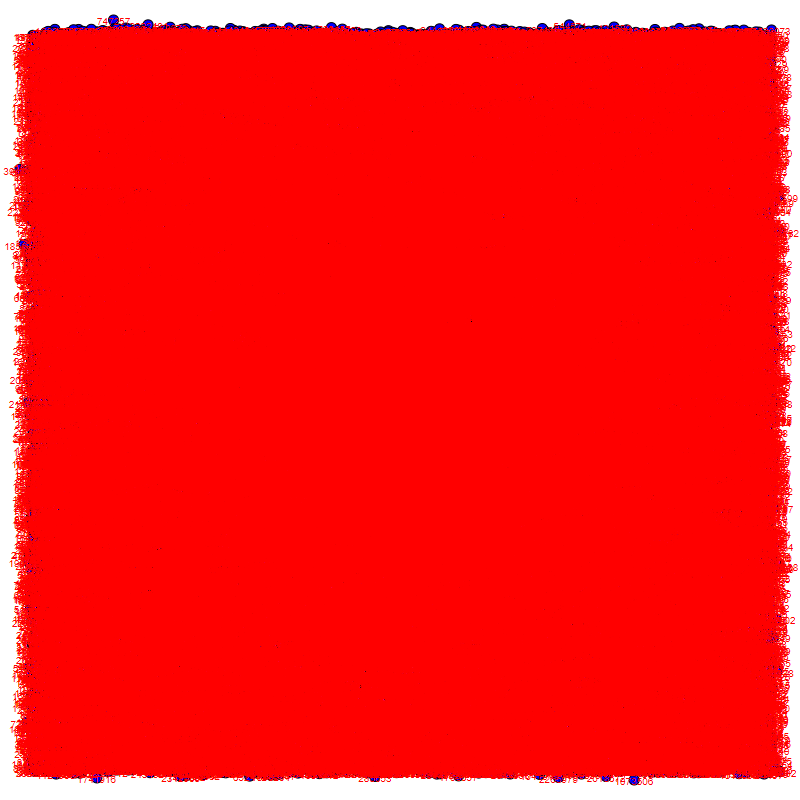

In [11]:
from IPython.display import Image, display

# Display the generated PNG image
output_file = "graph.png"
display(Image(filename=output_file))

## Generate Node Induced Subgraph

**Justification for Subgraph Generation**  

### Relevant Material  
Subgraph generation involves sampling and creating a subset of nodes and edges while preserving relationships.  

### Explanation  
1. **Node Sampling**: Randomly selects a subset of nodes.  
2. **Subgraph Extraction**: Uses PyTorch Geometric's `subgraph()` to create a node-induced subgraph, including edges connecting the sampled nodes.  
3. **Reindexing**: Reindexes nodes for independent structure.  
4. **Analysis**: Converts the subgraph to NetworkX for visualization and analysis.  

**NOTE**: This method is efficient and practical for large-scale graphs like `ogbn-products`.

Draw subgraph
Convert subgraph
Calculate the diameter
Approximated Diameter (based on largest connected subgraph): 37
Approximated Global Clustering Coefficient: 0.020064591380841382
create sample graph


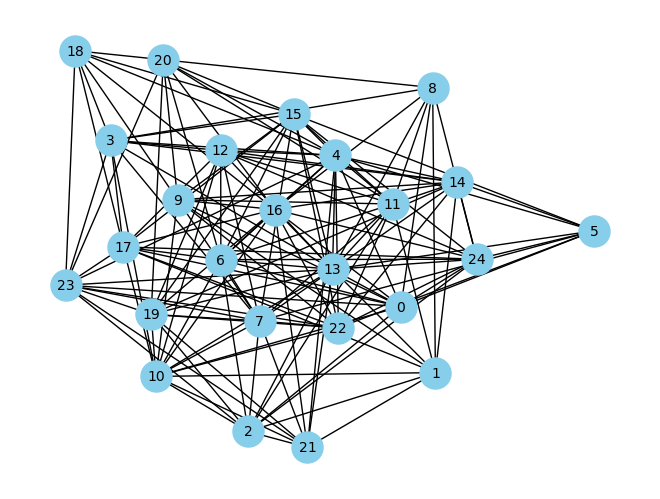

In [13]:
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.cluster import average_clustering

print("Draw subgraph")
# Parameters for sampling
num_sample_nodes = 20000  # Adjust this value based on available RAM
sample_nodes = random.sample(range(data.num_nodes), num_sample_nodes)

# Create a subgraph using sampled nodes
subset_edge_index, _ = subgraph(sample_nodes, data.edge_index, relabel_nodes=True)

# Convert the subgraph edges to a NetworkX graph
print("Convert subgraph")
G_sub = nx.Graph()
G_sub.add_edges_from(subset_edge_index.t().tolist())

# Ensure the subgraph is connected, otherwise work on the largest connected component
if not nx.is_connected(G_sub):
    largest_cc = max(nx.connected_components(G_sub), key=len)
    G_sub = G_sub.subgraph(largest_cc)

# Calculate the diameter for the largest connected component
print("Calculate the diameter")
diameter_approx = nx.diameter(G_sub)
print(f"Approximated Diameter (based on largest connected subgraph): {diameter_approx}")

# Convert the subgraph to a sparse adjacency matrix for clustering coefficient
adj_matrix = to_scipy_sparse_matrix(subset_edge_index, num_nodes=num_sample_nodes)

# Use NetworkX to compute clustering coefficient on the sampled graph
sampled_graph = nx.Graph(adj_matrix)
global_clustering_coeff_approx = average_clustering(sampled_graph, count_zeros=True)
print(f"Approximated Global Clustering Coefficient: {global_clustering_coeff_approx}")

# Create a sample graph
print("create sample graph")
G = nx.erdos_renyi_graph(25, 0.5)  # A random graph with 10 nodes and edge probability of 0.5

# Draw the graph

nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=10)

# Show the plot
#plt.show()

## Node embedding using 2-hop method for all nodes in subgraph using MP-GNN library in PyTorch Geometric
The flow would be,
- Extract features and edges for the subgraph (subgraph_x, subgraph_edge_index).
- Define the TwoHopGCN architecture with the required input, hidden, and output dimensions.
- Initialize an optimizer to train the model.




In [15]:
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch_geometric.data as geom_data

# Define a TwoHopGCN Model
class TwoHopGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(TwoHopGCN, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = self.relu(x)
        x = self.convs[-1](x, edge_index)
        return x

# Extract features and edge index for the subgraph
subgraph_x = data.x[sample_nodes]  # Subgraph node features
subgraph_edge_index = subset_edge_index  # Subgraph edges

# Define model parameters
sub_in_channels = subgraph_x.size(1)
sub_hidden_channels = 64
sub_out_channels = 64
sub_num_layers = 2  # Use 2-hop aggregation
learning_rate = 0.01

# Initialize TwoHopGCN model, optimizer, and loss function
subgraph_model = TwoHopGCN(sub_in_channels, sub_hidden_channels, sub_out_channels, sub_num_layers)
sub_optimizer = torch.optim.Adam(subgraph_model.parameters(), lr=learning_rate)

## Plot Subgrpah and compute their Diameter

Generate node embeddings for the subgraph using the trained TwoHopGCN model.

Generated Node Embeddings Shape: torch.Size([20000, 64])


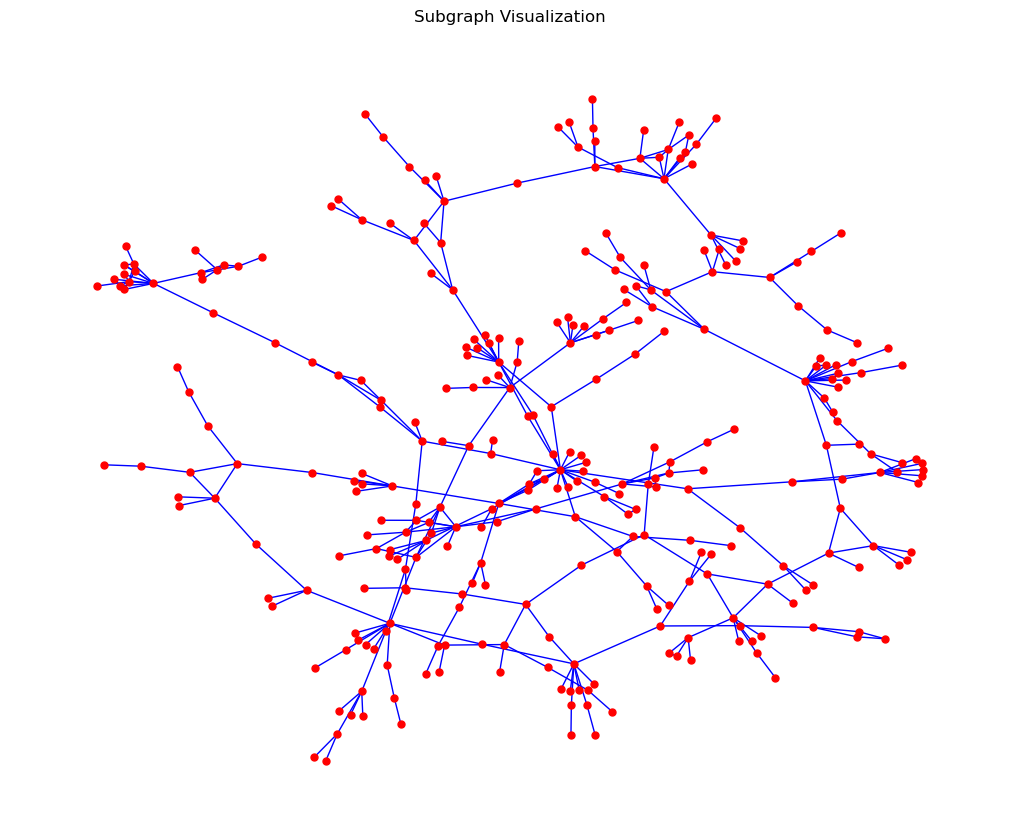

Updated Diameter (based on largest connected subgraph): 37


In [17]:

# Generate Node Embeddings for Subgraph
subgraph_model.eval()
with torch.no_grad():
    node_embeddings = subgraph_model(subgraph_x, subgraph_edge_index)
print("Generated Node Embeddings Shape:", node_embeddings.shape)

# Plot the Subgraph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub)  # Layout for better visualization
nx.draw(G_sub, pos, with_labels=False, node_color='red', edge_color='blue', node_size=25, font_size=10)
plt.title("Subgraph Visualization")
plt.show()

# Re-compute Diameter for Updated Subgraph
diameter_approx = nx.diameter(G_sub)
print(f"Updated Diameter (based on largest connected subgraph): {diameter_approx}")


### Justification:
We have taken only 20K nodes to create sub graph due to memory constraint. This can be adjusted into code with higher number of nodes.

### Observation:
The subgraph's diameter of 37 indicates that the farthest two nodes are separated by 37 hops, suggesting sparse connectivity or a widely spread structure. This could impact tasks requiring long-range information propagation, such as message passing in GCNs.